In [ ]:
import os, sys
import yaml
import torch
import numpy as np
from sklearn.decomposition import PCA
from tqdm import trange
from IPython.display import clear_output

%matplotlib inline

In [5]:
sys.path.append('..')

from src.costs import quadratic_cost, l2_squared_cost
from src.plotters import plot_results
from src.regularizers import entropic_regularizer, conservativity_regularizer
from src.mlp import MLPQuadratic

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0x000000); np.random.seed(0x000000)

# Benchmark setup

In [ ]:
!git clone https://github.com/iamalexkorotin/Wasserstein2Benchmark.git

In [ ]:
import Wasserstein2Benchmark.src.map_benchmark as mbm
%cd ./Wasserstein2Benchmark/src

# Experiment setup

In [27]:
DIM = 2
FIT_COST = l2_squared_cost
GAP_COST = quadratic_cost
base_path = os.path.join('../../../', 'experiments_data', 'wasserstein2')

with open(os.path.join(base_path, 'params.yaml')) as params_file:
    setup = yaml.safe_load(params_file)
    hidden_sizes = setup['hidden_sizes'][f'dim{DIM}']
    experiment_params = setup['le64params'] if DIM <= 64 else setup['ge128params']

In [32]:
benchmark = mbm.Mix3ToMix10Benchmark(DIM)
emb_X = PCA(n_components=2).fit(benchmark.input_sampler.sample(2**14).cpu().detach().numpy())
emb_Y = PCA(n_components=2).fit(benchmark.output_sampler.sample(2**14).cpu().detach().numpy())

In [33]:
model = MLPQuadratic(DIM, hidden_sizes).to(device)
model.gaussian_init(
    benchmark.input_sampler.sample(experiment_params['init_batch_size']),
    benchmark.output_sampler.sample(experiment_params['init_batch_size'])
)

optimizer = torch.optim.Adam(model.parameters(), lr=experiment_params['lr'])
scheduler = torch.optim.lr_scheduler.PolynomialLR(
    optimizer,
    total_iters=experiment_params['n_iters'],
    power=experiment_params['scheduler_power']
)

In [34]:
losses = {
    'Fit loss': [],
    'Monge gap': [],
    'Conservativity loss': [],
    'Total loss': []
}

# Training

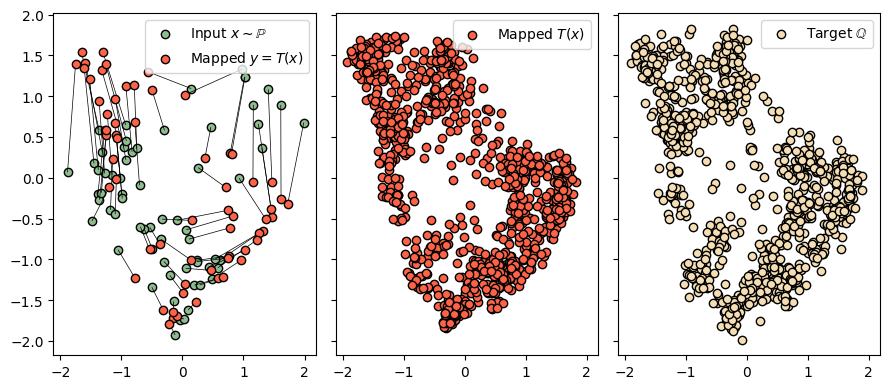

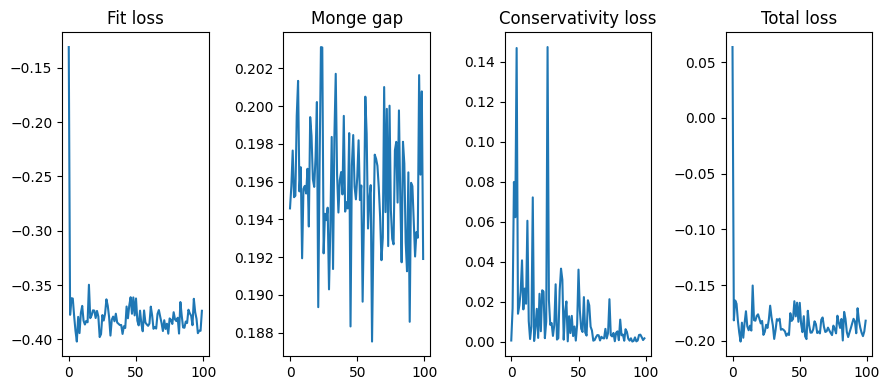

100%|██████████| 100000/100000 [3:41:45<00:00,  7.52it/s]


In [35]:
log_iters = experiment_params['n_iters'] // 100
mapping_batch_size = 1024

for iteration in trange(experiment_params['n_iters']):
    model.train(True)

    X = benchmark.input_sampler.sample(experiment_params['batch_size'])
    Y = benchmark.output_sampler.sample(experiment_params['batch_size'])
    T_X = model(X)

    fit_loss = entropic_regularizer(T_X, Y, FIT_COST)
    monge_gap = GAP_COST(X, T_X).mean() - entropic_regularizer(X, T_X, GAP_COST)
    conservativity_loss = conservativity_regularizer(model.mlp, X)
    loss = fit_loss + experiment_params['monge_gap_regularizer'] * monge_gap + experiment_params['conservativity_regularizer'] * conservativity_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if scheduler.get_last_lr()[0] > experiment_params['min_lr']:
        scheduler.step()

    if iteration % log_iters == 0:
        model.eval()

        clear_output(True)
        losses['Fit loss'].append(fit_loss.item())
        losses['Monge gap'].append(monge_gap.item())
        losses['Conservativity loss'].append(conservativity_loss.item())
        losses['Total loss'].append(loss.item())

        X_plot = benchmark.input_sampler.sample(mapping_batch_size)
        Y_plot = benchmark.output_sampler.sample(mapping_batch_size)

        with torch.no_grad():
            T_X_plot = model(X_plot)
        
        plot_results(X_plot, Y_plot, T_X_plot, losses, emb_X, emb_Y)

# Saving the model

In [36]:
torch.save(model.state_dict(), os.path.join('../../../', 'checkpoints', 'wasserstein2', f'd{DIM}_gauss.pt'))